In [1]:
# see https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# maybe look at this??? https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb
from minisom import MiniSom

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [2]:
input_dir_w6 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/"
# Load dataset

train_embeddings = np.load(input_dir_w6+'scBaseEncoderFeat_Z_bs250_tau0.5.npy')
print(train_embeddings.shape)

(41093, 5)


In [3]:
input_dir_w5 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/"

adata_train = ad.read_h5ad(input_dir_w5+'Larry_41093_2000_norm_log_cleaned.h5ad')

# adata_train.obs['Cell type annotation'] = adata_train.obs["cell_type"]
# adata_test.obs['Cell type annotation'] = adata_test.obs["cell_type"]
train_labels = adata_train.obs["clone_id"].to_numpy()
print(train_labels.shape)

(41093,)


In [4]:
# Create a boolean mask based on the condition in adata_train
mask = (adata_train.obs["time_info"] == 2.0)
# Subset adata_train based on the mask
adata_subset = adata_train[mask]

# Subset train_embeddings based on the same mask
train_embeddings_subset = train_embeddings[mask.to_numpy()]

In [5]:
som = MiniSom(15, 15,train_embeddings_subset.shape[1] , sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(train_embeddings_subset, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.13633392490201304


In [6]:
# Get the weights of the SOM after training
weights = som.get_weights()

# Calculate the U-matrix for visualization
umatrix = som.distance_map()

xx, yy = som.get_euclidean_coordinates()

<Axes: >

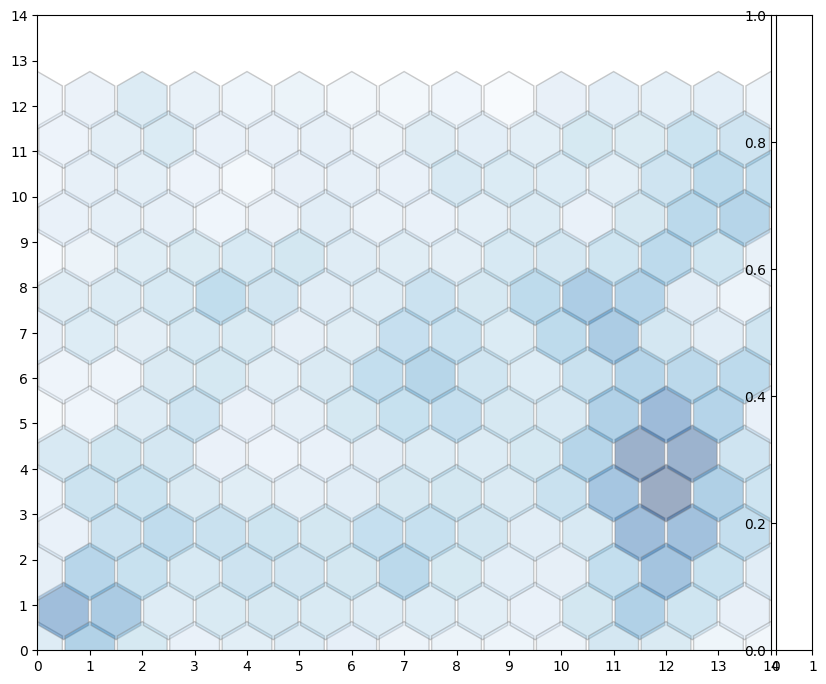

In [7]:
# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

In [18]:
class SOMClustering:
    def __init__(self, som_weights, topology='hexagonal', max_cluster_size=None):
        self.som_weights = som_weights  # SOM weights (neurons x features)
        self.topology = topology
        self.distances = None  # Distance map to store distances between neighbors
        self.segments = None   # Segment labels for each neuron
        self.max_cluster_size = max_cluster_size  # Max size for any single cluster
    
    def calculate_distance_map(self):
        """Calculates the distance between adjacent neurons."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        distance_map = np.full((rows, cols, 6), np.nan)  # 6 neighbors for hex topology
        
        # Neighboring indices for even and odd rows (hexagonal grid)
        ii_even = [1, 1, 1, 0, -1, 0] 
        jj_even = [1, 0, -1, -1, 0, 1]
        ii_odd = [0, 1, 0, -1, -1, -1]
        jj_odd = [1, 0, -1, -1, 0, 1]
        
        for x in range(rows):
            for y in range(cols):
                w_2 = self.som_weights[x, y]
                neighbors = ii_even if y % 2 == 0 else ii_odd
                jj = jj_even if y % 2 == 0 else jj_odd
                for k, (i, j) in enumerate(zip(neighbors, jj)):
                    if 0 <= x + i < rows and 0 <= y + j < cols:
                        w_1 = self.som_weights[x + i, y + j]
                        distance_map[x, y, k] = np.linalg.norm(w_2 - w_1)
                        
        return distance_map
    
    def merge_segments(self, distance_map, num_segments):
        """Merges segments based on distance until the desired number of segments is reached."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        segment_labels = np.arange(rows * cols).reshape(rows, cols)  # Each neuron starts as its own segment
        
        # Neighboring indices for even and odd rows
        ii_even = [1, 1, 1, 0, -1, 0] 
        jj_even = [1, 0, -1, -1, 0, 1]
        ii_odd = [0, 1, 0, -1, -1, -1]
        jj_odd = [1, 0, -1, -1, 0, 1]

        # Precompute and update cluster sizes
        cluster_sizes = {i: 1 for i in np.unique(segment_labels)}  # Initially, each neuron is its own cluster

        while np.unique(segment_labels).size > num_segments:
            min_dist = np.inf
            to_merge = None
            
            for x in range(rows):
                for y in range(cols):
                    for k, dist in enumerate(distance_map[x, y]):
                        if not np.isnan(dist) and dist < min_dist:
                            nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                            if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                                seg1 = segment_labels[x, y]
                                seg2 = segment_labels[nx, ny]
                                # Check if merging would exceed the max cluster size
                                size_seg1 = cluster_sizes[seg1]
                                size_seg2 = cluster_sizes[seg2]
                                if self.max_cluster_size is None or (size_seg1 + size_seg2 <= self.max_cluster_size):
                                    min_dist = dist
                                    to_merge = ((x, y), (nx, ny))
            
            # Break the loop if no valid merges are found (prevents infinite loops)
            if to_merge is None:
                break
            
            # Merge the segments
            seg1, seg2 = segment_labels[to_merge[0]], segment_labels[to_merge[1]]
            segment_labels[segment_labels == seg2] = seg1  # Merge segments
            cluster_sizes[seg1] += cluster_sizes.pop(seg2)  # Update cluster size
            
            # Update the distance map for the newly merged segment
            self.update_distances(segment_labels, distance_map)
        
        return segment_labels
    
    def update_distances(self, segment_labels, distance_map):
        """Update the distances between segments after a merge."""
        rows, cols = segment_labels.shape
        
        # Neighboring indices for even and odd rows
        ii_even = [1, 1, 1, 0, -1, 0] 
        jj_even = [1, 0, -1, -1, 0, 1]
        ii_odd = [0, 1, 0, -1, -1, -1]
        jj_odd = [1, 0, -1, -1, 0, 1]

        # Recalculate distances between neurons that are in different segments
        for x in range(rows):
            for y in range(cols):
                for k, dist in enumerate(distance_map[x, y]):
                    if not np.isnan(dist):
                        nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                        if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                            distance_map[x, y, k] = np.linalg.norm(self.som_weights[x, y] - self.som_weights[nx, ny])
    
    def fit(self, num_segments=8):
        """Performs the SOM clustering."""
        # Step 1: Calculate the distance map
        distance_map = self.calculate_distance_map()
        
        # Step 2: Merge segments iteratively until num_segments are reached
        self.segments = self.merge_segments(distance_map, num_segments)
        
        return self.segments


In [19]:
# Assume som_weights is a 2D array of neurons (rows, cols, features)
som_clustering = SOMClustering(weights, max_cluster_size=50)
segments = som_clustering.fit(num_segments=6)

print(segments)  # Each neuron now has a segment label

[[  0   0  15  15  15  34  34  34   8   9   9   9   9   9   9]
 [ 15  15  15  15  15  34  34  34  34   9   9   9   9   9   9]
 [ 15  15  15  15  34  34  34  34  34   9   9   9   9   9   9]
 [ 15  15  15  15  34  34  34  34  34  54   9   9   9   9   9]
 [ 15  15  15  15  34  34  34  34  34  34   9   9   9   9   9]
 [ 15  15  15  15  34  34  34  34  34  34   9   9   9   9   9]
 [ 15  15  15  15  34  34  34  34  34  34   9   9   9   9   9]
 [ 15  15  15  15  34  34  34 112  34   9   9   9   9   9   9]
 [ 15  15  15  15  34  34 126  34 170   9   9   9   9 170 170]
 [ 15  15  15  15  34  34  34  34 170   9   9 170 170 170 170]
 [ 15  15  15  15  34  34  34  34 170 170 170 170 170 170 170]
 [ 15  15  15  15  15 170 170 170 170 170 170 170 170 170 170]
 [183 183 183 183 183 183 170 170 170 170 170 170 170 170 170]
 [183 183 183 183 183 183 183 183 170 170 170 170 170 170 170]
 [183 183 183 183 183 183 183 183 170 170 170 170 170 170 170]]


In [15]:
weights.shape

(15, 15, 5)

/tmp/ipykernel_3271806/1055568470.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters


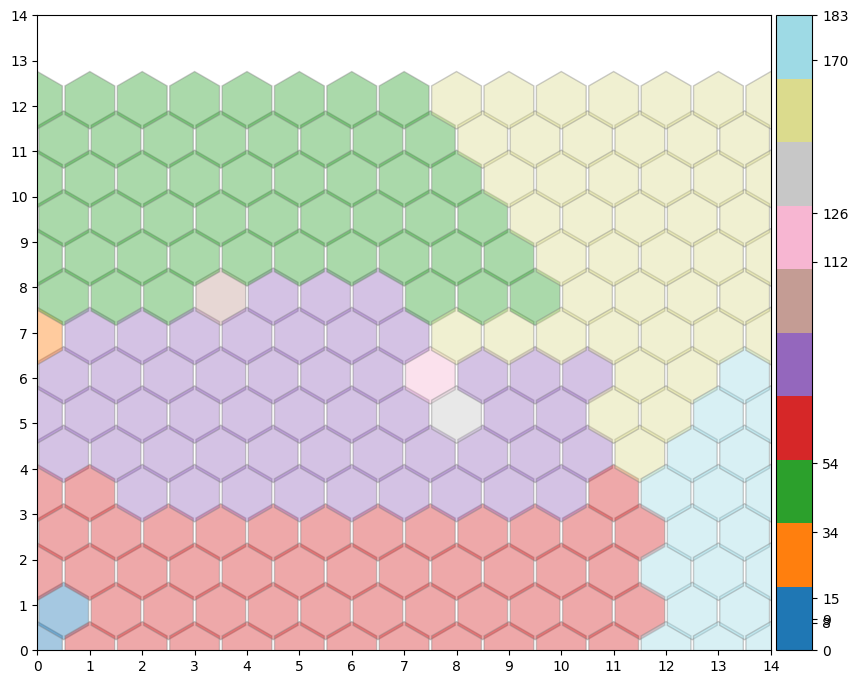

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'segments' is your 2D array where each neuron has a cluster label
# Example: segments = np.random.randint(0, 8, (20, 20))

# Create a colormap for the clusters
unique_segments = np.unique(segments)
cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        
        # Get the cluster of the current neuron
        cluster = segments[i, j]
        
        # Use the cluster label to get a color from the colormap
        hex_color = cmap(np.where(unique_segments == cluster)[0][0])
        
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color,  # Color by cluster
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

# Set the axis range and labels
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange - .5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Optional: Add color bar for clusters
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

# Create a color bar with the unique clusters
norm = plt.Normalize(vmin=min(unique_segments), vmax=max(unique_segments))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=ax_cb, ticks=unique_segments)

plt.show()


Bring in the anndata

In [22]:
# Load the metadata file
metadata_file = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/LARRY_tabulate-lineages.csv"
metadata_df = pd.read_csv(metadata_file, sep=",")

In [23]:
# Concatenate 'Library' and 'Cell barcode' in filtered_metadata to create unique barcodes
metadata_df['combined_barcode'] = metadata_df['Library'] + ':' + metadata_df['Cell.barcode']

In [24]:
# Convert the 'Library' and 'Cell barcode' columns to string before concatenating
adata_subset.obs['Library_str'] = adata_subset.obs['Library'].astype(str)
adata_subset.obs['Cell barcode_str'] = adata_subset.obs['Cell barcode'].astype(str)

# Ensure 'adata' also has 'Library' and 'Cell barcode' columns in the same format
# Create a new 'combined_barcode' column in adata
adata_subset.obs['combined_barcode'] = adata_subset.obs['Library_str'] + ':' + adata_subset.obs['Cell barcode_str']

/tmp/ipykernel_3271806/579885139.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['Library_str'] = adata_subset.obs['Library'].astype(str)


In [25]:
import pandas as pd

# Convert adata.obs to a pandas DataFrame
adata_obs_df = adata_subset.obs.copy()

# Merge with metadata_df on the 'Cell barcode' column
merged_df = adata_obs_df.merge(metadata_df[['combined_barcode', 'assignment']], 
                               left_on='combined_barcode', right_on='combined_barcode', 
                               how='left')

In [26]:
# Add the 'assignment' column back to adata.obs
adata_subset.obs['assignment'] = merged_df['assignment'].values

# Now adata.obs has the assignment column for each cell barcode present in adata

In [27]:
adata_subset.obs['assignment'].value_counts()

assignment
Other               1483
Neutrophil           103
Undifferentiated      85
Monocyte              75
Name: count, dtype: int64

In [28]:
# Optionally, subset the labels if needed
assignment_vec = adata_subset.obs['assignment'].to_numpy()

In [29]:
# Set the amount of jitter (tune this as needed)
jitter_amount = 0.1

/tmp/ipykernel_3271806/2548681324.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters


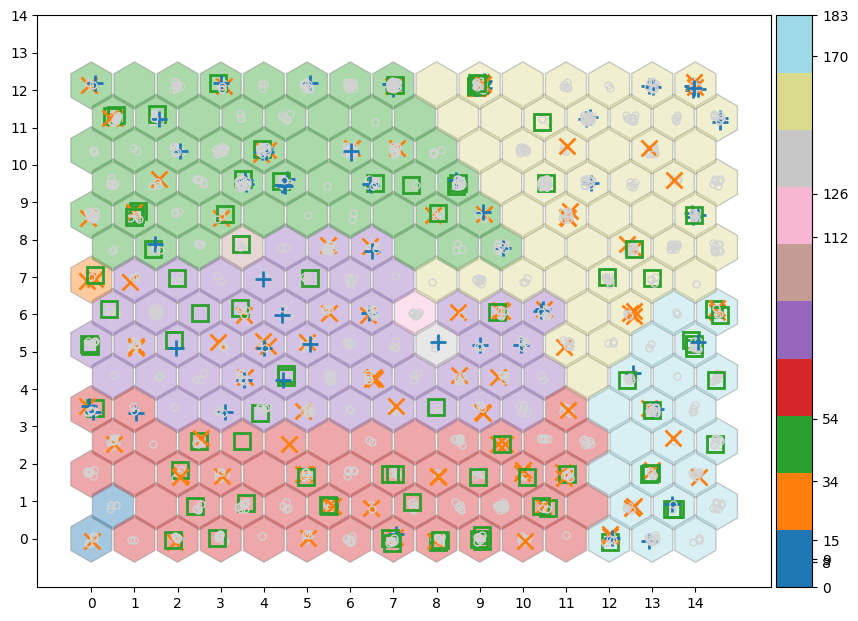

In [32]:
# Create a colormap for the clusters
unique_segments = np.unique(segments)
cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        
        # Get the cluster of the current neuron
        cluster = segments[i, j]
        
        # Use the cluster label to get a color from the colormap
        hex_color = cmap(np.where(unique_segments == cluster)[0][0])
        
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color,  # Color by cluster
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

# Plot data points on the SOM grid
for cnt, x in enumerate(train_embeddings_subset):
    w = som.winner(x)  # Find the winning neuron
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2

    # Apply jitter to the coordinates
    wx = wx + np.random.uniform(-jitter_amount, jitter_amount)
    wy = wy + np.random.uniform(-jitter_amount, jitter_amount)

    label = assignment_vec[cnt]
    if label == "Monocyte":
        # Assign marker and color based on the label
        plt.plot(wx, wy, '+', 
                 markerfacecolor='None', markeredgecolor='C0', 
                 markersize=12, markeredgewidth=2)
    elif label == "Neutrophil":
        # Assign marker and color based on the label
        plt.plot(wx, wy, 'x', 
                 markerfacecolor='None', markeredgecolor='C1', 
                 markersize=12, markeredgewidth=2)
    elif label == "Undifferentiated":
        # Assign marker and color based on the label
        plt.plot(wx, wy, 's', 
                 markerfacecolor='None', markeredgecolor='C2', 
                 markersize=12, markeredgewidth=2)
    else:
         # Plot all other points in light gray
        plt.plot(wx, wy, 'o', markerfacecolor='None', markeredgecolor='lightgray', 
                 markersize=5, markeredgewidth=1)


xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Optional: Add color bar for clusters
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

# Create a color bar with the unique clusters
norm = plt.Normalize(vmin=min(unique_segments), vmax=max(unique_segments))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=ax_cb, ticks=unique_segments)

plt.show()
